# **Monotonic constraints experiments**

# **Set-up**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
pio.templates.default = "simple_white"
warnings.filterwarnings('ignore')

# Import ML
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef
from catboost import CatBoostClassifier, Pool


In [38]:
train_uncleaned = pd.read_csv('Data/train.csv') # includes the original data 
test_uncleaned = pd.read_csv('Data/test.csv') # includes the original data 
train = pd.read_csv('Data/train_cleaned.csv') # includes the original data 
test = pd.read_csv('Data/test_cleaned.csv')
original = pd.read_csv('Data/original_cleaned.csv')
train.drop(columns=['cgpa_bucket'], inplace=True)
train.head()

,is_female,age,city,is_student,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,suicidal_thoughts,work_study_hours,financial_stress,family_history,depression,is_original
0,1,49,Ludhiana,0,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,0,1.0,2.0,0,0,0
1,0,26,Varanasi,0,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,1,7.0,3.0,0,1,0
2,0,33,Visakhapatnam,1,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1,0
3,0,22,Mumbai,0,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,1,10.0,1.0,1,1,0
4,1,30,Kanpur,0,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,1,9.0,4.0,1,0,0


# **Custom functions**

In [85]:
def train_bagged_model(
    X, 
    y, 
    model_params, 
    n_folds=5, 
    cat_features=None, 
    random_state=42
):
    """
    Train a bagged model using K-fold cross-validation approach.
    
    Args:
        X: Training features
        y: Target variable
        model_params: Parameters for CatBoostClassifier
        n_folds: Number of folds for cross-validation
        cat_features: List of categorical feature names
        random_state: Random seed
    
    Returns:
        oof_predictions: Out-of-fold predictions for training data
        models: List of trained models
    """
    # Initialize arrays for predictions
    oof_predictions = np.zeros(len(X))
    models = []
    
    # Initialize lists to store CV scores for each fold
    fold_mcc_scores = []
    fold_acc_scores = []
    fold_auc_scores = []
    
    # Create K-fold splits
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Train K models
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training fold {fold + 1}/{n_folds}")
        
        # Prepare training data
        train_data = Pool(
            X.iloc[train_idx],
            y.iloc[train_idx],
            cat_features=cat_features
        )
        val_data = Pool(
            X.iloc[val_idx],
            y.iloc[val_idx],
            cat_features=cat_features
        )
        
        # Initialize and train model
        model = CatBoostClassifier(
            **model_params,
            random_state=random_state + fold
        )
        
        model.fit(
            train_data,
            eval_set=val_data,
            early_stopping_rounds=50,
            verbose=0
        )
        
        # Generate OOF predictions for this fold
        fold_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
        oof_predictions[val_idx] = fold_preds
        
        # Calculate and store CV scores for this fold
        fold_mcc = matthews_corrcoef(y.iloc[val_idx], (fold_preds > 0.5).astype(int))
        fold_acc = accuracy_score(y.iloc[val_idx], (fold_preds > 0.5).astype(int))
        fold_auc = roc_auc_score(y.iloc[val_idx], fold_preds)
        
        fold_mcc_scores.append(fold_mcc)
        fold_acc_scores.append(fold_acc)
        fold_auc_scores.append(fold_auc)
        
        # Save model
        models.append(model)

    # Calculate mean and std of fold scores
    mean_mcc = np.mean(fold_mcc_scores)
    std_mcc = np.std(fold_mcc_scores)
    mean_acc = np.mean(fold_acc_scores)
    std_acc = np.std(fold_acc_scores)
    mean_auc = np.mean(fold_auc_scores)
    std_auc = np.std(fold_auc_scores)

    print(f"\nCross-validation Scores (Mean ± Std):")
    print(f"AUC Score: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"MCC Score: {mean_mcc:.4f} ± {std_mcc:.4f}")
    print(f"Accuracy Score: {mean_acc:.4f} ± {std_acc:.4f}")

    return oof_predictions, models

# **Relationship with the target**

In [3]:
# Lets see the relationship between the features and the target. 
# Separate numerical and categorical features
num_features = train.select_dtypes(include=['int32', 'float32']).columns.tolist()
cat_features = train.select_dtypes(include=['object', 'string']).columns.tolist()

# Remove target and is_original from features
num_features = [f for f in num_features if f not in ['depression', 'is_original']]
cat_features = [f for f in cat_features if f not in ['depression', 'is_original']]

In [18]:
# Remove target and is_original
features = [f for f in train.columns if f not in ['depression', 'is_original']]

# Calculate depression rate for each feature value
fig = make_subplots(rows=len(features)//3 + 1, cols=3, 
                    subplot_titles=features)

for i, feat in enumerate(features):
    # Calculate proportions
    props = (train.fillna({feat: -1 if original[feat].dtype.kind in 'biufc' else 'NA'})
            .groupby(feat)['depression']
            .agg(['count', 'mean'])
            .assign(pct=lambda x: x['mean'] * 100)
            .round(2)
            .sort_values('mean', ascending=False))
    
    # Add count as hover text
    hover_text = [f"Count: {c}" for c in props['count']]
    
    fig.add_trace(
        go.Bar(x=props.index, 
               y=props['pct'], 
               text=props['pct'].apply(lambda x: f"{x:.1f}%"),
               hovertext=hover_text,
               name=feat),
        row=i//3 + 1, col=i%3 + 1
    )

fig.update_layout(height=300*((len(features)//3) + 1), 
                 width=1000, 
                 showlegend=False,
                 title_text="Depression Rate by Feature Values")
fig.show()

The results are very interesting:

- Beign younger (age < 20), student increases significantly the probability of having depression. Students in particularly is a defining factor in this dataset.
- As expected, ordered features correlate with depression:
    - `academic_pressure`, `work_pressure`, `financial_stress`, `work_study_hours` as it increases, the probability of having depression increases.
    - `study_satisfaction`, `job_satisfaction` as it decreases, the probability of having depression increases.
- Having bad `dietary_habits` and `sleep_duration` decreases the probability of having depression.
- `Gender` and `family_history` do not show a strong correlation with depression. However, they may have interaction with other features.
- `Graphic Designer` is the top profession with high proportion of depression.
- `Hyderabad` is the top city with high proportion of depression. This could be biased because there are more students living there and also is an importante tech hub in India where there is high academic pressure.
- Having `suicidal_thoughts` is not a good sign, 31% of the people with suicidal thoughts have depression, whereas only 5% of the people without suicidal thoughts have depression.
- `Class 12` in India is a crucial year in a student's life because it is the year when students take very important exams that may determine their future. This may explain why there is a high proportion of depression in this group.
- **Missing Values** usually have a high proportion of depression in certain features like `work_pressure`, `financial_stress` because all of the NAs are practically students. Whereas, missing values in student related features like `academic_pressure`, `study_satisfaction` have low proportions of depression because there are not students. 

# **Encoding ordinal features**

In [51]:
# academic pressure
academic_pressure_mapping = {
    -1: 0,  # lowest depression rate
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6
}

# work pressure
work_pressure_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    -1: 6
}

# study satisfaction
study_satisfaction_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    -1: 6
}

# Job satisfaction
job_satisfaction_mapping = {
    -1: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5
}

# Sleep duration (ordering based on depression rates)
sleep_mapping = {
    'Missing': 2,                  # middle depression rate
    'Less than 5 hours': 0,   # highest depression rate
    '5-6 hours': 2,
    '7-8 hours': 1,
    'More than 8 hours': 3    # lowest depression rate
}


# Dietary habits (NA -> Healthy -> Moderate -> Unhealthy)
dietary_mapping = {
    'Missing': 0,        # highest depression rate
    'Unhealthy': 1,
    'Moderate': 2,
    'Healthy': 3    # lowest depression rate
}

# Work study hours
work_study_hours_mapping = {
    0: 1,
    1: 1,
    2: 2,
    3: 3,
    4: 3,
    5: 3,
    6: 5,
    7: 6,
    8: 7,
    9: 4,
    10: 8,
    11: 7,
    12: 8
}

# Financial stress
financial_stress_mapping = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    -1: 5,
    5: 6
}

In [69]:
# Function to apply custom mapping with missing values
def apply_custom_mapping(series, mapping):
    return series.map(mapping)

# Fill NaN in categorical features with 'Missing'
train_prep = train.copy()
test_prep = test.copy()

for feat in cat_features:
    train_prep[feat] = train_prep[feat].fillna('Missing')
    test_prep[feat] = test_prep[feat].fillna('Missing')

ordered_features = ['academic_pressure', 'work_pressure', 'study_satisfaction', 'job_satisfaction', 'financial_stress']
for feat in ordered_features:
    # Missing values in financial stress should be -1 for mapping to work
    train_prep[feat] = train_prep[feat].fillna(-1)
    test_prep[feat] = test_prep[feat].fillna(-1)

# Apply the mappings for train
train_prep['work_study_hours'] = apply_custom_mapping(train_prep['work_study_hours'], work_study_hours_mapping)
train_prep['financial_stress'] = apply_custom_mapping(train_prep['financial_stress'], financial_stress_mapping)
train_prep['academic_pressure'] = apply_custom_mapping(train_prep['academic_pressure'], academic_pressure_mapping)
train_prep['dietary_habits'] = apply_custom_mapping(train_prep['dietary_habits'], dietary_mapping).astype(int)
train_prep['sleep_duration'] = apply_custom_mapping(train_prep['sleep_duration'], sleep_mapping).astype(int)
train_prep['work_pressure'] = apply_custom_mapping(train_prep['work_pressure'], work_pressure_mapping)
train_prep['job_satisfaction'] = apply_custom_mapping(train_prep['job_satisfaction'], job_satisfaction_mapping)
train_prep['study_satisfaction'] = apply_custom_mapping(train_prep['study_satisfaction'], study_satisfaction_mapping)

# Apply the mappings for test 
test_prep['academic_pressure'] = apply_custom_mapping(test_prep['academic_pressure'], academic_pressure_mapping)
test_prep['dietary_habits'] = apply_custom_mapping(test_prep['dietary_habits'], dietary_mapping)
test_prep['sleep_duration'] = apply_custom_mapping(test_prep['sleep_duration'], sleep_mapping)
test_prep['work_study_hours'] = apply_custom_mapping(test_prep['work_study_hours'], work_study_hours_mapping)
test_prep['financial_stress'] = apply_custom_mapping(test_prep['financial_stress'], financial_stress_mapping)
test_prep['work_pressure'] = apply_custom_mapping(test_prep['work_pressure'], work_pressure_mapping)
test_prep['job_satisfaction'] = apply_custom_mapping(test_prep['job_satisfaction'], job_satisfaction_mapping)
test_prep['study_satisfaction'] = apply_custom_mapping(test_prep['study_satisfaction'], study_satisfaction_mapping)

In [70]:
# Remove target and is_original
features = [f for f in train_prep.columns if f not in ['depression', 'is_original']]

# Calculate depression rate for each feature value
fig = make_subplots(rows=len(features)//3 + 1, cols=3, 
                    subplot_titles=features)

for i, feat in enumerate(features):
    # Calculate proportions
    props = (train_prep
            .groupby(feat)['depression']
            .agg(['count', 'mean'])
            .assign(pct=lambda x: x['mean'] * 100)
            .round(2)
            .sort_values('mean', ascending=False))
    
    # Add count as hover text
    hover_text = [f"Count: {c}" for c in props['count']]
    
    fig.add_trace(
        go.Bar(x=props.index, 
               y=props['pct'], 
               text=props['pct'].apply(lambda x: f"{x:.1f}%"),
               hovertext=hover_text,
               name=feat),
        row=i//3 + 1, col=i%3 + 1
    )

fig.update_layout(height=300*((len(features)//3) + 1), 
                 width=1000, 
                 showlegend=False,
                 title_text="Depression Rate by Feature Values")
fig.show()

# **Testing monotonic constraints with catboost**


In [71]:
# Split train/test
X = train_prep[features]
y = train_prep['depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [79]:
# Define multiple scoring metrics
scoring = {
    'AUC': 'roc_auc',
    'MCC': 'matthews_corrcoef',
    'ACC': 'accuracy'
}

cat_features = ['profession', 'city', 'degree']

# Default CatBoost parameters
catboost_params = {
    'depth': 6,
    'learning_rate': 0.01,
    'l2_leaf_reg': 3,
    'random_strength': 4,
    'eval_metric': 'MCC',
    'loss_function': 'Logloss',
    'iterations': 1000,
    'scale_pos_weight': 1.5
}

# Define monotonic constraints
monotone_constraints = {
    'academic_pressure': 1,
    'financial_stress': 1,
    'work_study_hours': 1,
    'work_pressure': 1,
    'study_satisfaction': -1,
    'job_satisfaction': -1,
    'dietary_habits': -1,
    'sleep_duration': -1
}

monotonic_params = {
    'depth': 6,
    'learning_rate': 0.01,
    'l2_leaf_reg': 3,
    'random_strength': 4,
    'eval_metric': 'MCC',
    'loss_function': 'Logloss',
    'iterations': 1000,
    'scale_pos_weight': 1.5,
    'monotone_constraints': monotone_constraints
}

## **Baseline**

In [81]:
# Run cross-validation once with multiple metrics
baseline_cv = cross_validate(
    CatBoostClassifier(**catboost_params, random_state=42, verbose=False),
    X_train,
    y_train,
    cv=10,
    scoring=scoring,
    fit_params={'cat_features': cat_features},
    n_jobs=-1,
    verbose=1
)

# Print results
for metric in scoring.keys():
    scores = baseline_cv[f'test_{metric}']
    print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC: 0.9751 ± 0.0019
MCC: 0.7964 ± 0.0059
ACC: 0.9382 ± 0.0017


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.6min finished


## **Monotonic constraints**

In [82]:
# Run cross-validation once with multiple metrics
monotone_cv = cross_validate(
    CatBoostClassifier(**monotonic_params, random_state=42, verbose=False),
    X_train,
    y_train,
    cv=10,
    scoring=scoring,
    fit_params={'cat_features': cat_features},
    n_jobs=-1,
    verbose=1
)

# Print results
for metric in scoring.keys():
    scores = monotone_cv[f'test_{metric}']
    print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC: 0.9749 ± 0.0018
MCC: 0.7940 ± 0.0066
ACC: 0.9371 ± 0.0019


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.4min finished


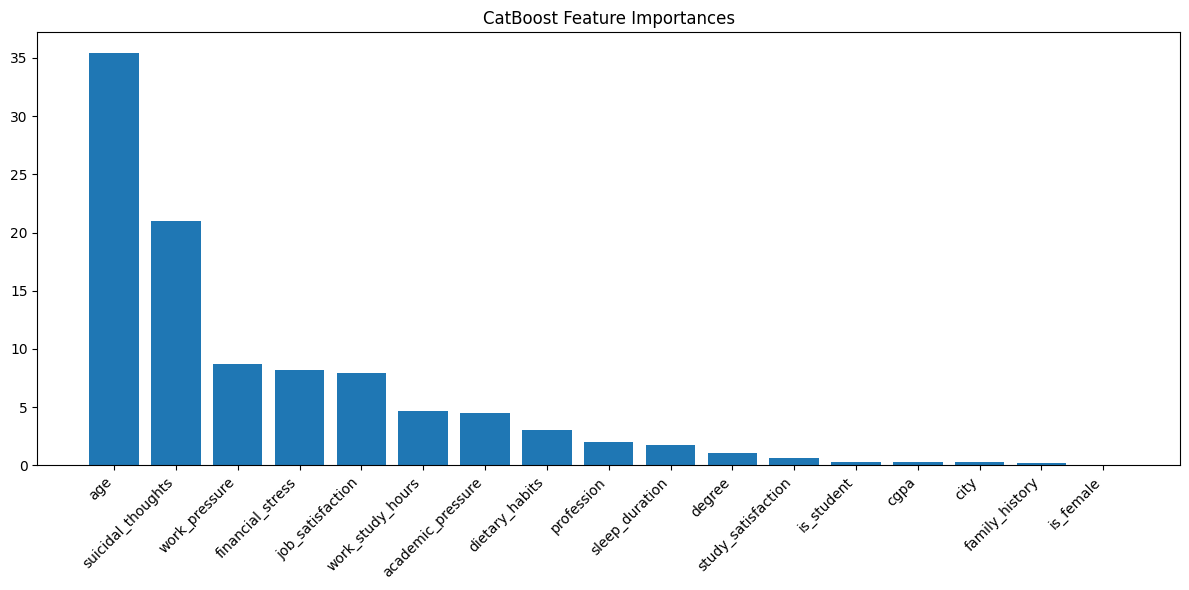


Feature Importances:
               feature  importance
1                  age   35.422627
13   suicidal_thoughts   21.023524
6        work_pressure    8.731309
15    financial_stress    8.198116
9     job_satisfaction    7.917695
14    work_study_hours    4.665031
5    academic_pressure    4.460463
11      dietary_habits    3.023816
4           profession    2.037237
10      sleep_duration    1.760481
12              degree    1.025274
8   study_satisfaction    0.598258
3           is_student    0.307163
7                 cgpa    0.295394
2                 city    0.279434
16      family_history    0.222131
0            is_female    0.032050


In [83]:
# Train a final model on the full training set to get feature importances
final_model = CatBoostClassifier(**catboost_params, random_state=42, verbose=False)
final_model.fit(X_train, y_train, cat_features=cat_features)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
})

# Sort by importance
importances = importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(importances['feature'], importances['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('CatBoost Feature Importances')
plt.tight_layout()
plt.show()


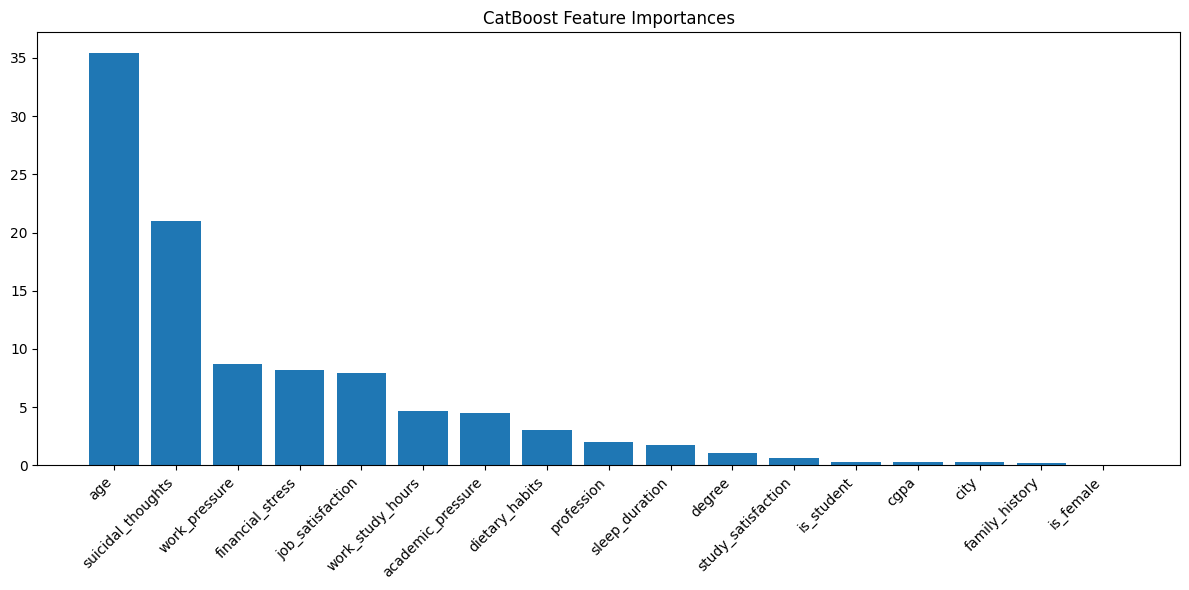


Feature Importances:
               feature  importance
1                  age   35.422627
13   suicidal_thoughts   21.023524
6        work_pressure    8.731309
15    financial_stress    8.198116
9     job_satisfaction    7.917695
14    work_study_hours    4.665031
5    academic_pressure    4.460463
11      dietary_habits    3.023816
4           profession    2.037237
10      sleep_duration    1.760481
12              degree    1.025274
8   study_satisfaction    0.598258
3           is_student    0.307163
7                 cgpa    0.295394
2                 city    0.279434
16      family_history    0.222131
0            is_female    0.032050


In [84]:
# Train a final model on the full training set to get feature importances
final_model2 = CatBoostClassifier(**monotonic_params, random_state=42, verbose=False)
final_model2.fit(X_train, y_train, cat_features=cat_features)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
})

# Sort by importance
importances = importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(importances['feature'], importances['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('CatBoost Feature Importances')
plt.tight_layout()
plt.show()


## **Bagged models**

In [ ]:
# Generate 10 Bagged Catboost models
m2_oof_preds, m2_models = train_bagged_model(
    X=X_train,
    y=y_train,
    model_params=best_params,
    n_folds=20,
    cat_features=cat_features
)